In [1]:
import torch as th
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

from DINCAE import DINCAE_pconvs
from preprocessing.dataset_normalization import MinMaxNormalization

In [6]:
result_idx = 1
dataset_idx = 2

data_path = Path("../data/")
dataset_path = data_path / Path(f"minimal_datasets/dataset_{dataset_idx}.pt")
# weights_path = data_path / Path(f"weights/weights_{result_idx}.pt")
weights_path = data_path / Path(f"weights_to_sync/weights_{result_idx}.pt")
nans_masks_path = data_path / Path(f"nans_masks/nans_mask_{dataset_idx}.pt")
minmax_path = data_path / Path(f"minmax_vals/minmax_{dataset_idx}.pt")

for path in [dataset_path, weights_path, nans_masks_path, minmax_path]:
    if not path.exists():
        raise FileNotFoundError(f"Path {path} does not exist.")

dataset = th.load(dataset_path)
weights = th.load(weights_path)
nans_masks = th.load(nans_masks_path)
minmax = th.load(minmax_path)

In [7]:
# Retieve dataset specs
n_channels = 5
nrows = 128
ncols = 128
n_images = 5000
masked_channels = [0, 1]

In [8]:
model = DINCAE_pconvs(params_path=Path("params.json"),
                      n_channels=n_channels,
                      image_nrows=nrows,
                      image_ncols=ncols,
                      middle_channels= [16, 30, 58,110, 209],
                        kernel_sizes=[3, 3, 3, 3, 3],
                        pooling_sizes=[2, 2, 2, 2, 2],
                        interp_mode="bilinear",
                        output_size=n_channels)

model.load_state_dict(weights)

<All keys matched successfully>

In [ ]:

# n_reconstructed_images = 10

# # Get n_reconstructed_images random images
# random_indices = np.random.choice(n_images, n_reconstructed_images, replace=False)

# reconstructed_images = th.ones((n_reconstructed_images, n_channels, nrows, ncols))
# original_images = th.ones((n_reconstructed_images, n_channels, nrows, ncols))

# norm_class = MinMaxNormalization(1000)
# for i, idx in enumerate(random_indices):
#     image = dataset["images"][idx].unsqueeze(0)
#     denorm_image = norm_class.denormalize(image, minmax)
#     mask = dataset["masks"][idx].unsqueeze(0)
#     original_image = dataset["images"][idx].unsqueeze(0)
#     nans_mask = nans_masks[idx].unsqueeze(0)
    
#     output, _ = model(image, mask)
#     denorm_output = norm_class.denormalize(output, minmax)
    
#     original_images[i] = th.where(nans_mask == 0, denorm_image, th.nan)
    
#     reconstructed_image = th.where(mask == 0, denorm_output, original_images[i]) # Where mask is 0, use the output, else use the original image
    
#     reconstructed_images[i] = th.where(nans_mask == 0, denorm_output, th.nan)
    
    

In [68]:

n_reconstructed_images = 10

# Get n_reconstructed_images random images
random_indices = np.random.choice(n_images, n_reconstructed_images, replace=False)

reconstructed_images = th.ones((n_reconstructed_images, n_channels, nrows, ncols))
original_images = th.ones((n_reconstructed_images, n_channels, nrows, ncols))

for i, idx in enumerate(random_indices):
    image = dataset["images"][idx].unsqueeze(0)
    mask = dataset["masks"][idx].unsqueeze(0)
    original_image = dataset["images"][idx].unsqueeze(0)
    nans_mask = nans_masks[idx].unsqueeze(0)
    
    output, _ = model(image, mask)
    
    output = th.where(mask == 0, output, image) # Where the mask is 0, use the output, otherwise use the image
    
    reconstructed_images[i] = th.where(nans_mask == 0, th.nan, output) # Where the nans mask is 0, use the nans
    original_images[i] = th.where(nans_mask == 0, th.nan, image) # Where the nans mask is 0, use the nans
    
    

Reconstructed image min: 0.9723792672157288, max: 296.7900085449219


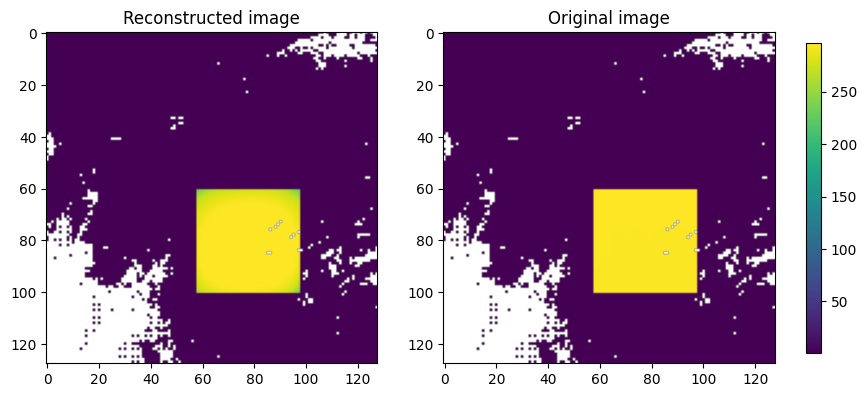

In [69]:
random_idx = np.random.randint(0, n_reconstructed_images)

reconstructed_image = reconstructed_images[random_idx][masked_channels[0]].detach().numpy()
original_image = original_images[random_idx][masked_channels[0]].detach().numpy()

# Determine global vmin and vmax to ensure same colormap scaling
vmin = np.nanmin([original_image])
vmax = np.nanmax([original_image])

print(f"Reconstructed image min: {vmin}, max: {vmax}")

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

im0 = axs[0].imshow(reconstructed_image, vmin=vmin, vmax=vmax)
axs[0].set_title("Reconstructed image")

im1 = axs[1].imshow(original_image, vmin=vmin, vmax=vmax)
axs[1].set_title("Original image")

# Shared colorbar using one of the images
fig.colorbar(im1, ax=axs, orientation='vertical', fraction=0.02, pad=0.04)

plt.show()
